**Important**: This notebook only works together with the oggm dev branch at the moment and requires SALib to be installed.

In [ ]:
#!pip install SALib

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from oggm import utils, workflow, tasks, cfg
from oggm.core.massbalance import MonthlyTIModel

import SALib.sample.sobol as sampler
import SALib.analyze.sobol as analyser

# Set up a gdir to play with

In [2]:
cfg.initialize(logging_level="WARNING")

working_dir = 'working_dir_mcs'
utils.mkdir(working_dir)
cfg.PATHS["working_dir"] = working_dir

2025-08-29 13:06:04: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-08-29 13:06:04: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-08-29 13:06:04: oggm.cfg: Multiprocessing: using all available processors (N=8)


In [3]:
rgi_ids = ["RGI60-06.00377"]
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/elev_bands/W5E5/'
gdirs = workflow.init_glacier_directories(
        rgi_ids,
        from_prepro_level=3,
        prepro_border=10,
        prepro_rgi_version="62",
        prepro_base_url=base_url,
    )

gdir = gdirs[0]

2025-08-29 13:06:04: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2025-08-29 13:06:04: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


In [4]:
# Redo calibration to get the observations values stored in the observations file (prepro gdirs are not created with dev)
workflow.execute_entity_task(tasks.mb_calibration_from_hugonnet_mb,
                             gdirs,
                             informed_threestep=True,  # only available for 'GSWP3_W5E5'
                            );

2025-08-29 13:06:04: oggm.workflow: Execute entity tasks [mb_calibration_from_hugonnet_mb] on 1 glaciers


# Define a workflow to play with

Here you need to define a function which takes all parameters which are included in the uncertainty porpagation. Those parameters include observations (in my example reference mass balance `ref_mb`) and model parameters (in my example `melt_f`, `prcp_fac` and `temp_bias`). The function should conduct the calibration and potentially also a dynamic model run. All results should be stored using the `settings_filesuffix`.

Notes on the new handling of settings and observations:

- **Observations**: In observations, the convention is that the variable name should match the function’s kwarg. For example, `tasks.mb_calibration_from_scalar_mb` has the kwargs `ref_mb`, `ref_mb_period`, and `ref_mb_err`. Therefore, in the observations we use the key `ref_mb`. The actual value is stored under `observations['ref_mb']['value']`, and the other parameters are stored without repeating `ref_mb`. For example, `ref_mb_period` is stored as `observations['ref_mb']['period']`.
- **Settings with a parent file**: A settings file can have a parent. If a parameter is not found in the current file, it will be taken from the parent. By default, the parent is `cfg.PARAMS`. You can change this by setting `parent_filesuffix`. In my example, I use this feature to ensure all parameters are consistent with the default calibration.
- **Calibrated parameters**: After calibration, the parameters are written back into the settings file with the chosen `settings_filesuffix`. This means that after running `tasks.mb_calibration_from_scalar_mb`, you will find the calibrated parameters in the settings under this suffix. In some cases, the initial guess of a parameter may also come from the settings and later be overwritten with the calibrated values. In the future, we might want to add safeguards for this.

In [5]:
def mcs_mb_calibration(gdir, settings_filesuffix, settings_parent_filesuffix,
                       observations_filesuffix,
                       ref_mb, ref_mb_period, ref_mb_err,
                       prcp_fac, melt_f, temp_bias,
                      ):
    # add observations data to observations file
    gdir.observations_filesuffix = observations_filesuffix
    gdir.observations['ref_mb'] = {'err': ref_mb_err,
                                   'period': ref_mb_period,
                                   'value': ref_mb}

    # create the new settings file with the correct parent_filesuffix
    utils.ModelSettings(gdir, filesuffix=settings_filesuffix,
                        parent_filesuffix=settings_parent_filesuffix)
    gdir.settings_filesuffix = settings_filesuffix
    gdir.settings['use_winter_prcp_fac'] = False  # this is checked in mb_calibration_from_scalar_mb

    # the settings here mimic mb_calibration_from_hugonnet_mb
    workflow.execute_entity_task(tasks.mb_calibration_from_scalar_mb,
                                 gdir,
                                 settings_filesuffix=settings_filesuffix,
                                 observations_filesuffix=observations_filesuffix,
                                 overwrite_gdir=True,
                                 calibrate_param1='prcp_fac',
                                 calibrate_param2='melt_f',
                                 calibrate_param3='temp_bias',
                                 prcp_fac=prcp_fac,
                                 prcp_fac_min=prcp_fac * 0.8,
                                 prcp_fac_max=prcp_fac * 1.2,
                                 melt_f=melt_f,
                                 temp_bias=temp_bias,
                                 mb_model_class=MonthlyTIModel,
                                )

# Create sample of input parameters

Here we define the distribution of the parameters we consider (observations and model parameters). This example here was just a quick setup for testing the principle workflow and need to be refined carefully depending on the application and the used type of observation. 

Here an overview which kind of distributions can be used and the meaning of 'bounds' depending on the selected distribution: https://salib.readthedocs.io/en/latest/user_guide/advanced.html#generating-alternate-distributions

## define parameter distributions

I included here a small in between step for defining the parameters in a more readable way and only at the end convert it into the format which is expected by the sampler.

In [6]:
# to have a better overview I provide the parameter distribution in a more readable way first
parameter_distribution = {}

# add geodetic mb observation
gdir.observations_filesuffix = ''  # just to be sure to use the correct observations
ref_mb = gdir.observations['ref_mb']
parameter_distribution['ref_mb'] = {
    'bounds': [ref_mb['value'] - ref_mb['err'],  # this need to be checked again if we should use +/-err/2
               ref_mb['value'] + ref_mb['err']],
    'dists': 'unif'  # need to be checked
}

# add mb parameter distributions (they are made up and need to be decided somehow)
gdir.settings_filesuffix = ''
parameter_distribution['prcp_fac'] = {
    'bounds': [max(gdir.settings['prcp_fac'] * 0.5, gdir.settings['prcp_fac_min']),
               min(gdir.settings['prcp_fac'] * 1.5, gdir.settings['prcp_fac_max'])
              ],
    'dists': 'unif'
}
parameter_distribution['melt_f'] = {
    'bounds': [max(gdir.settings['melt_f'] - 1, gdir.settings['melt_f_min']),
               min(gdir.settings['melt_f'] + 1, gdir.settings['melt_f_max'])],
    'dists': 'unif'
}
parameter_distribution['temp_bias'] = {
    'bounds': [max(gdir.settings['temp_bias'] - 0.5, gdir.settings['temp_bias_min']),
               min(gdir.settings['temp_bias'] + 0.5, gdir.settings['temp_bias_max'])],
    'dists': 'unif'
}

# now convert to format which is expected by SALib
num_vars = 0
problem = {
    'names': [],
    'bounds': [],
    'dists': [],
}

for key in parameter_distribution:
    num_vars += 1
    problem['names'].append(key)
    problem['bounds'].append(parameter_distribution[key]['bounds'])
    problem['dists'].append(parameter_distribution[key]['dists'])
problem['num_vars'] = num_vars

In [7]:
problem

{'names': ['ref_mb', 'prcp_fac', 'melt_f', 'temp_bias'],
 'bounds': [[-700.3000000000001, -564.9],
  [1.1682545377091955, 3.5047636131275866],
  [4.0, 6.0],
  [-0.7619605322613461, 0.23803946773865398]],
 'dists': ['unif', 'unif', 'unif', 'unif'],
 'num_vars': 4}

## create actual samples

Creating the actual sample is quite easy again. For more information on the sampling method you can read up the references provided in the sampler docstring `sampler.sample?`.

In [9]:
# sampler.sample?

In [10]:
# the total number of samples created is 
# - including second order interconnections: N * (2 * num_vars + 2)
# - or only look at uncorrelated sensitivity with calc_second_order=False: N * (num_vars + 2)
N = 2**5  # if using second order this needs to be a power of 2
param_values = sampler.sample(problem, N, calc_second_order=True)

In [11]:
param_values.shape

(320, 4)

# execute a calibration for each parameter setting

Here I loop through all samples and execute my function I defined above. For this we probably could utilize multiprocessing in the future (one option would be to make our function an entity_task and use the execute_entity_task logic).

In [12]:
# for the reference mass balance we provide the same error and mb_period as the original observation
gdir.observations_filesuffix = ''
ref_mb = gdir.observations['ref_mb']

for i, param_val in enumerate(param_values):
    print(f"{i + 1}/{param_values.shape[0]}")
    mcs_mb_calibration(gdir,
                       settings_filesuffix=f'_{i}',
                       settings_parent_filesuffix='',
                       observations_filesuffix=f'_{i}',
                       ref_mb_period=ref_mb['period'],
                       ref_mb_err=ref_mb['err'],
                       ref_mb=param_val[problem['names'].index('ref_mb')],
                       prcp_fac=param_val[problem['names'].index('prcp_fac')],
                       melt_f=param_val[problem['names'].index('melt_f')],
                       temp_bias=param_val[problem['names'].index('temp_bias')],
                      )

2025-08-29 13:06:09: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:09: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:09: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:09: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


1/320
2/320
3/320
4/320


2025-08-29 13:06:09: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:09: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:09: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:09: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


5/320
6/320
7/320
8/320


2025-08-29 13:06:10: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:10: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:10: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:10: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


9/320
10/320
11/320
12/320


2025-08-29 13:06:10: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:10: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:10: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:10: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


13/320
14/320
15/320
16/320


2025-08-29 13:06:10: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:10: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:10: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:10: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


17/320
18/320
19/320
20/320


2025-08-29 13:06:10: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:10: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:10: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:10: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


21/320
22/320
23/320
24/320


2025-08-29 13:06:10: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:10: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:11: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:11: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


25/320
26/320
27/320
28/320


2025-08-29 13:06:11: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:11: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:11: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:11: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


29/320
30/320
31/320
32/320


2025-08-29 13:06:11: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:11: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:11: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:11: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


33/320
34/320
35/320
36/320


2025-08-29 13:06:11: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:11: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:11: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:11: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


37/320
38/320
39/320
40/320


2025-08-29 13:06:11: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:11: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:11: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:11: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


41/320
42/320
43/320
44/320


2025-08-29 13:06:12: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:12: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:12: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:12: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


45/320
46/320
47/320
48/320


2025-08-29 13:06:12: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:12: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:12: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:12: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


49/320
50/320
51/320
52/320


2025-08-29 13:06:12: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:12: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:12: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:12: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


53/320
54/320
55/320
56/320


2025-08-29 13:06:12: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:12: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:12: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:12: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


57/320
58/320
59/320
60/320


2025-08-29 13:06:12: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:12: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:13: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:13: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


61/320
62/320
63/320
64/320


2025-08-29 13:06:13: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:13: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:13: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:13: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


65/320
66/320
67/320
68/320


2025-08-29 13:06:13: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:13: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:13: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


69/320
70/320
71/320


2025-08-29 13:06:13: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:13: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:13: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:13: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


72/320
73/320
74/320
75/320


2025-08-29 13:06:13: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:13: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:14: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:14: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


76/320
77/320
78/320
79/320


2025-08-29 13:06:14: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:14: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:14: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:14: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


80/320
81/320
82/320
83/320


2025-08-29 13:06:14: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:14: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:14: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:14: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


84/320
85/320
86/320
87/320


2025-08-29 13:06:14: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:14: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:14: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:14: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


88/320
89/320
90/320
91/320


2025-08-29 13:06:14: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:14: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:14: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:14: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


92/320
93/320
94/320
95/320


2025-08-29 13:06:15: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:15: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:15: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:15: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


96/320
97/320
98/320
99/320


2025-08-29 13:06:15: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:15: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:15: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:15: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


100/320
101/320
102/320
103/320


2025-08-29 13:06:15: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:15: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:15: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:15: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


104/320
105/320
106/320
107/320


2025-08-29 13:06:15: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:15: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:15: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:15: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


108/320
109/320
110/320
111/320


2025-08-29 13:06:15: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:16: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:16: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:16: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


112/320
113/320
114/320
115/320


2025-08-29 13:06:16: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:16: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:16: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:16: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


116/320
117/320
118/320
119/320


2025-08-29 13:06:16: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:16: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:16: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:16: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


120/320
121/320
122/320
123/320


2025-08-29 13:06:16: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:16: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:16: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


124/320
125/320
126/320


2025-08-29 13:06:16: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:16: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:16: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:17: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


127/320
128/320
129/320
130/320


2025-08-29 13:06:17: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:17: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:17: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:17: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


131/320
132/320
133/320
134/320


2025-08-29 13:06:17: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:17: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:17: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:17: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


135/320
136/320
137/320
138/320


2025-08-29 13:06:17: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:17: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:17: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:17: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


139/320
140/320
141/320
142/320


2025-08-29 13:06:17: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:17: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:17: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:17: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


143/320
144/320
145/320
146/320


2025-08-29 13:06:17: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:18: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:18: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:18: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


147/320
148/320
149/320
150/320


2025-08-29 13:06:18: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:18: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:18: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:18: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


151/320
152/320
153/320
154/320


2025-08-29 13:06:18: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:18: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:18: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:18: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


155/320
156/320
157/320
158/320


2025-08-29 13:06:18: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:18: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:18: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


159/320
160/320
161/320
162/320


2025-08-29 13:06:18: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:18: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:19: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:19: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


163/320
164/320
165/320


2025-08-29 13:06:19: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:19: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:19: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:19: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


166/320
167/320
168/320
169/320
170/320


2025-08-29 13:06:19: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:19: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:19: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:19: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:19: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


171/320
172/320
173/320
174/320


2025-08-29 13:06:19: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:19: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:19: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:19: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


175/320
176/320
177/320
178/320


2025-08-29 13:06:19: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:19: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:19: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:20: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


179/320
180/320
181/320
182/320
183/320


2025-08-29 13:06:20: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:20: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:20: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:20: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:20: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


184/320
185/320
186/320
187/320
188/320


2025-08-29 13:06:20: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:20: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:20: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:20: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:20: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


189/320
190/320
191/320
192/320


2025-08-29 13:06:20: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:20: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:20: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:20: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


193/320
194/320
195/320
196/320


2025-08-29 13:06:20: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:20: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:20: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:20: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


197/320
198/320
199/320
200/320


2025-08-29 13:06:21: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:21: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:21: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:21: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


201/320
202/320
203/320
204/320


2025-08-29 13:06:21: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:21: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:21: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:21: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


205/320
206/320
207/320
208/320


2025-08-29 13:06:21: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:21: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:21: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:21: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


209/320
210/320
211/320
212/320


2025-08-29 13:06:21: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:21: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:21: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:21: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


213/320
214/320
215/320
216/320


2025-08-29 13:06:21: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:21: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:22: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:22: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


217/320
218/320
219/320
220/320


2025-08-29 13:06:22: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:22: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:22: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:22: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


221/320
222/320
223/320
224/320


2025-08-29 13:06:22: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:22: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:22: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:22: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


225/320
226/320
227/320
228/320


2025-08-29 13:06:22: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:22: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:22: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


229/320
230/320
231/320


2025-08-29 13:06:22: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:22: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:22: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:22: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


232/320
233/320
234/320
235/320


2025-08-29 13:06:23: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:23: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:23: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:23: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


236/320
237/320
238/320
239/320


2025-08-29 13:06:23: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:23: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:23: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:23: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


240/320
241/320
242/320
243/320


2025-08-29 13:06:23: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:23: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:23: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:23: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


244/320
245/320
246/320
247/320


2025-08-29 13:06:23: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:23: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:23: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:23: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


248/320
249/320
250/320
251/320


2025-08-29 13:06:23: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:23: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:24: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:24: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


252/320
253/320
254/320
255/320


2025-08-29 13:06:24: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:24: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:24: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:24: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


256/320
257/320
258/320
259/320


2025-08-29 13:06:24: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:24: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:24: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:24: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


260/320
261/320
262/320
263/320


2025-08-29 13:06:24: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:24: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:24: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:24: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


264/320
265/320
266/320
267/320


2025-08-29 13:06:24: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:24: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:24: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:25: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


268/320
269/320
270/320
271/320


2025-08-29 13:06:25: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:25: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:25: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:25: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


272/320
273/320
274/320
275/320


2025-08-29 13:06:25: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:25: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:25: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:25: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


276/320
277/320
278/320
279/320


2025-08-29 13:06:25: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:25: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:25: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:25: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


280/320
281/320
282/320
283/320
284/320


2025-08-29 13:06:25: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:25: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:25: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:25: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:25: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


285/320
286/320
287/320
288/320


2025-08-29 13:06:25: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:26: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:26: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:26: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


289/320
290/320
291/320
292/320


2025-08-29 13:06:26: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:26: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:26: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:26: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


293/320
294/320
295/320
296/320


2025-08-29 13:06:26: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:26: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:26: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:26: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


297/320
298/320
299/320
300/320


2025-08-29 13:06:26: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:26: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:26: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:26: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


301/320
302/320
303/320
304/320


2025-08-29 13:06:26: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:26: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:26: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:26: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


305/320
306/320
307/320
308/320
309/320


2025-08-29 13:06:27: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:27: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:27: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:27: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:27: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


310/320
311/320
312/320
313/320


2025-08-29 13:06:27: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:27: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:27: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:27: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


314/320
315/320
316/320
317/320


2025-08-29 13:06:27: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:27: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers
2025-08-29 13:06:27: oggm.workflow: Execute entity tasks [mb_calibration_from_scalar_mb] on 1 glaciers


318/320
319/320
320/320


# Look at results

## resulting distribution of mb parameters

Here just look at the resulting mass balance parameters after calibration. We initialized all with a uniform distribution.

In [13]:
# default run parameters
gdir.settings_filesuffix = ''
prcp_fac_default = gdir.settings['prcp_fac']
melt_f_default = gdir.settings['melt_f']
temp_bias_default = gdir.settings['temp_bias']

prcp_fac_all = []
melt_f_all  =[]
temp_bias_all = []

for i in range(param_values.shape[0]):
    gdir.settings_filesuffix = f'_{i}'
    prcp_fac_all.append(gdir.settings['prcp_fac'])
    melt_f_all.append(gdir.settings['melt_f'])
    temp_bias_all.append(gdir.settings['temp_bias'])

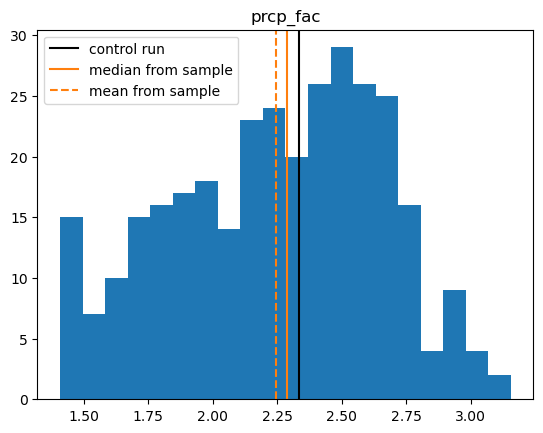

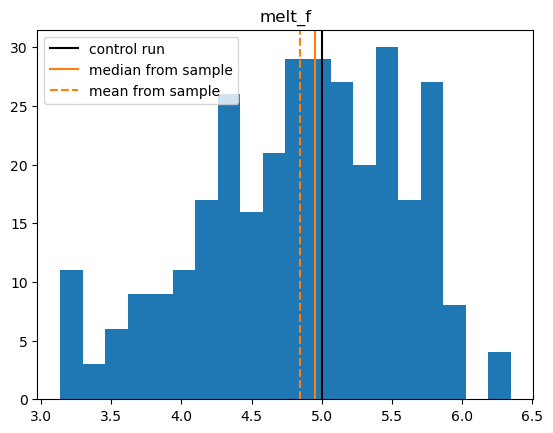

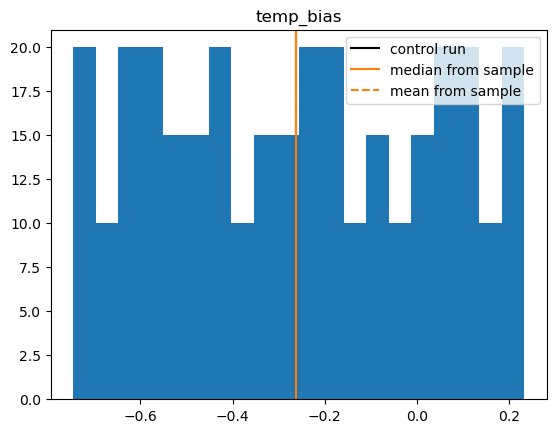

In [14]:
def plt_parameter_distribution(para_all, para_default, title, bins=20):
    plt.hist(para_all, bins=bins, color='C0')
    plt.axvline(para_default, c='k', label='control run')
    plt.axvline(np.median(para_all), c='C1', label='median from sample')
    plt.axvline(np.mean(para_all), c='C1', ls='--', label='mean from sample')
    plt.title(title)
    plt.legend()
    plt.show()

plt_parameter_distribution(prcp_fac_all,
                           prcp_fac_default,
                           'prcp_fac',
                           bins=20)

plt_parameter_distribution(melt_f_all,
                           melt_f_default,
                           'melt_f',
                           bins=20)

plt_parameter_distribution(temp_bias_all,
                           temp_bias_default,
                           'temp_bias',
                           bins=20)


## pick one year and look at distribution of resulting mb values

Here we visualize the uncertainty for the specific mass balance for the period 1980 to 2020 as defined by the MCS sample.

In [15]:
fls = gdir.read_pickle('inversion_flowlines')
years = np.arange(1980, 2020)

# get control run (= current default OGGM calibration)
mb_mod = MonthlyTIModel(gdir, settings_filesuffix='')
specific_mb_default = mb_mod.get_specific_mb(fls=fls, year=years)

# now get values from MCS sample
specific_mb_all = []
for i in range(param_values.shape[0]):
    mb_mod = MonthlyTIModel(gdir, settings_filesuffix=f'_{i}')
    specific_mb_all.append(mb_mod.get_specific_mb(fls=fls, year=years))
specific_mb_all = np.array(specific_mb_all)

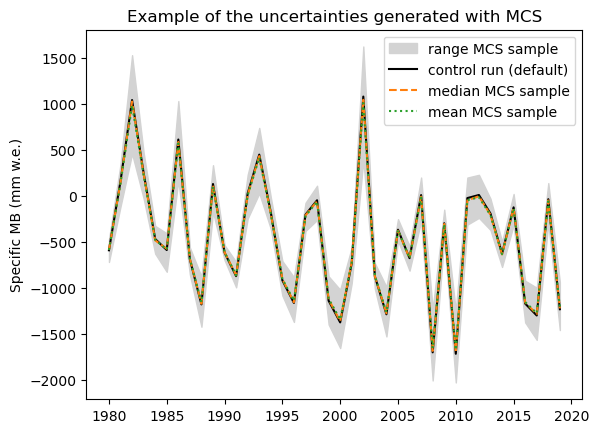

In [21]:
plt.fill_between(years, np.min(specific_mb_all, axis=0), np.max(specific_mb_all, axis=0),
                 color='lightgray', label=f'range MCS sample')

plt.plot(years, specific_mb_default, '-k', label='control run (default)')
plt.plot(years, np.median(specific_mb_all, axis=0), 'C1--', label='median MCS sample')
plt.plot(years, np.mean(specific_mb_all, axis=0), 'C2:', label='mean MCS sample')
plt.title('Example of the uncertainties generated with MCS')
plt.ylabel('Specific MB (mm w.e.)')
plt.legend()
plt.show()

# Bonus: Get sensitivities (not needed at this stage of DTC-Glaciers)

This is not needed at the moment. But the idea is that you also can analyze how much of the variance of a result is comming from the observations and how much from the model parameters. This could become interesting in a next phase of DTC-Glaciers.

In [17]:
# compare how much of the variance for one year is comming from the observation and how much from the model
yr = 2000

# now get values from MCS runs
specific_mb_yr = []
for i in range(param_values.shape[0]):
    mb_mod = MonthlyTIModel(gdir, settings_filesuffix=f'_{i}')
    specific_mb_yr.append(mb_mod.get_specific_mb(fls=fls, year=yr))
specific_mb_yr = np.array(specific_mb_yr)

In [25]:
Si = analyser.analyze(problem, specific_mb_yr, print_to_console=True)

                 ST   ST_conf
ref_mb     0.069132  0.032055
prcp_fac   0.959213  0.480933
melt_f     0.121303  0.084683
temp_bias  0.137700  0.103872
                 S1   S1_conf
ref_mb     0.092887  0.140456
prcp_fac   0.702130  0.488540
melt_f     0.196756  0.183623
temp_bias  0.061604  0.192858
                             S2   S2_conf
(ref_mb, prcp_fac)     0.019816  0.263528
(ref_mb, melt_f)      -0.101128  0.186669
(ref_mb, temp_bias)   -0.095322  0.200636
(prcp_fac, melt_f)    -0.025813  0.641291
(prcp_fac, temp_bias)  0.047332  0.615218
(melt_f, temp_bias)   -0.026448  0.307664


How to read this (from my amateur point of few, without digging into the references):

In the first order sensitivities S1 we see the largest portion of the sensitivity of the 2000 specific mass balance is comming from the precipitation factor followed by the melt_factor.

To get a more indepth understanding have a look at the references provided in the docstring `analyser.analyze?`.

In [26]:
# analyser.analyze?